<a href="https://colab.research.google.com/github/MASQA/DSTraining/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0__jun_ml_kaggle_hw_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings('ignore')

In [3]:
yourEnv =[]
while True:
    yourEnv = input('Send 1 if you work in your OS,\n insert 2 if you work in GoogleDrive: ')
    if yourEnv == '1' :
        path_hw= "./data/"
        break
    elif yourEnv == '2' :
        from google.colab import drive
        drive.mount("/content/drive")
        path_hw = "/content/drive/My Drive/DataScience/ML_B/ML_1_10.4HW/"
        break
    else:
        print('There is no such variant.Please try again')



Send 1 if you work in your OS,
 insert 2 if you work in GoogleDrive: 2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load in the train and test datasets
train = pd.read_csv(path_hw + 'train.csv')
test = pd.read_csv(path_hw + 'test.csv')
titanic = pd.read_csv(path_hw + 'titanic.csv')
# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,1
1,1,1,0,38.0,1,0,71.2833,2
2,1,3,0,26.0,0,0,7.9250,1
3,1,1,0,35.0,1,0,53.1000,1
4,0,3,1,35.0,0,0,8.0500,1
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,1
887,1,1,0,19.0,0,0,30.0000,1
888,0,3,0,27.0,1,2,23.4500,1
889,1,1,1,26.0,0,0,30.0000,2


In [8]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [9]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [10]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


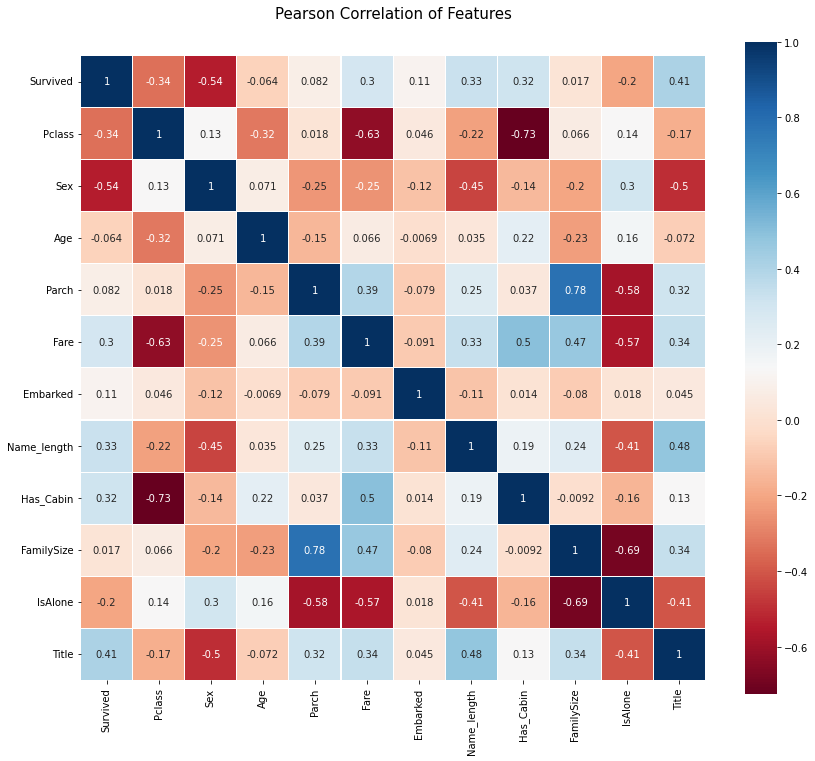

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

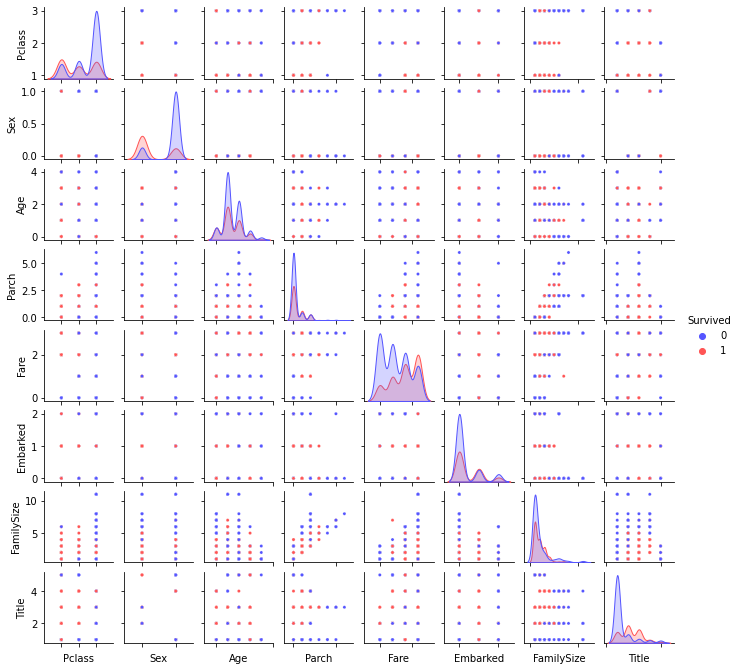

In [12]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

In [13]:
train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,1,0,1,0,21,0,1,1,5
887,1,1,0,1,0,2,0,28,1,1,1,2
888,0,3,0,1,2,2,0,40,0,4,0,2
889,1,1,1,1,0,2,1,21,1,1,1,1


Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [14]:
# Разбиение и валидация данных
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     cross_val_predict)

# Базовые
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Мета
from xgboost import XGBClassifier

# Метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score



In [15]:
# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

In [16]:
# готовим GradientBoostingClassifier
gbc =  GradientBoostingClassifier(random_state=17)
gbc_gs = GridSearchCV(gbc, gbc_params, cv = skf)

In [17]:
# готовим RandomForestClassifier
rfc =  RandomForestClassifier(random_state=17)
rfc_gs = GridSearchCV(rfc, rfc_params, cv = skf)

In [18]:
# готовим SVC
svc =  SVC(random_state=17)
svc_gs = GridSearchCV(svc, svc_params, cv = skf)

In [19]:
# готовим LogisticRegression
lr =  LogisticRegression(random_state=17)
lr_gs = GridSearchCV(lr, lr_params, cv = skf)

In [20]:
# готовим выборки
targets = train.Survived
data = train.drop(columns='Survived')
x_train, x_valid, y_train, y_valid = train_test_split(data, targets, test_size=.3, random_state=17)


In [21]:
data

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,1
1,1,0,2,0,3,1,51,1,2,0,3
2,3,0,1,0,1,0,22,0,1,1,2
3,1,0,2,0,3,0,44,1,2,0,3
4,3,1,2,0,1,0,24,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,1,0,1,0,21,0,1,1,5
887,1,0,1,0,2,0,28,1,1,1,2
888,3,0,1,2,2,0,40,0,4,0,2
889,1,1,1,0,2,1,21,1,1,1,1


### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [22]:
def fit_and_report(model, data, target, data_valid, target_valid, resultIsModel = True):
  model_resolve = model.fit(data, target)
  print(f'Model: {model}')
  print(f'Best params: {model_resolve.best_params_}')
  model_prediction = model_resolve.predict(data_valid)
  print(f'Accuracy : {accuracy_score(target_valid, model_prediction)}')
  return model_resolve, model_prediction
ready_models = []
models = [gbc_gs, rfc_gs, svc_gs, lr_gs]
meta_mtrx = np.empty((x_valid.shape[0], len(models)))
meta_mtrx.shape


(268, 4)

In [32]:
meta_mtrx

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [23]:
for n, model in enumerate(models):
  model_resolve, model_prediction = fit_and_report(model, x_train, y_train, x_valid, y_valid)
  meta_mtrx[:,n] = model_prediction
  ready_models.append(model_resolve)

Model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=17),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5])})
Best params: {'learning_rate': 0.1}
Accuracy : 0.7611940298507462
Model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(random_state=17),
             param_grid={'min_samples_leaf': range(1, 5),
                         'n_estimators': range(10, 100, 10)})
Best params: {'min_samples_leaf': 3, 'n_estimators': 80}
Accuracy : 0.7873134328358209
Model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(random_state=17),
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'kernel': ['linear', 'rbf']})
Best params: {'C': 0.1, 'kernel': 'linear'}
Accuracy : 0.7873134328358209
Model: GridSearchCV(cv=Stratifi

Видим, что, из базовых алгоритмов, логистическая регрессия дает лучшее значение метрики 

### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [24]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [25]:
meta_mtrx.shape

(268, 4)

In [26]:
y_valid

890    0
498    0
664    1
261    1
716    1
      ..
150    0
499    0
7      0
736    0
34     0
Name: Survived, Length: 268, dtype: int64

In [27]:
meta_alg = XGBClassifier(random_state = 17)
meta_alg_gs = GridSearchCV(meta_alg, xgb_params, cv = skf)
# for n, model in enumerate(ready_models):  
#   print(f'Work with model {model}')
#   meta_mtrx[:, n] = cross_val_predict(model, x_train, y_train, cv = skf, method='predict');
#   ready_model = model.fit(x_train, y_train)
#   ready_models.append(ready_model)
# meta_alg
print(f'Meta matrix {meta_mtrx.shape}')
print(f'Y matrix {y_valid.shape}')
meta_model = meta_alg_gs.fit(meta_mtrx,y_valid)



Meta matrix (268, 4)
Y matrix (268,)


In [28]:
print(f'Meta model: {meta_model}')
print(f'Best params: {meta_model.best_params_}')

Meta model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=XGBClassifier(random_state=17),
             param_grid={'eta': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'min_child_weight': range(1, 10),
                         'n_estimators': range(10, 100, 5),
                         'subsample': array([0.1, 0.3, 0.5, 0.7, 0.9])})
Best params: {'eta': 0.1, 'min_child_weight': 2, 'n_estimators': 40, 'subsample': 0.7000000000000001}


In [29]:

meta_mtrx_test = np.empty((x_valid.shape[0], len(ready_models)))
meta_mtrx_test.shape


(268, 4)

In [30]:
for n, ready_model in enumerate(ready_models):
      meta_mtrx_test[:, n] = ready_model.predict(x_valid)

In [31]:
meta_predict = meta_alg_gs.predict(meta_mtrx_test)
print(f'Accuracy : {accuracy_score(y_valid, meta_predict)}')

Accuracy : 0.8134328358208955


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [ ]:
def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5):
  if test_size is None:
    ready_models = []
    meta_mtrx = np.empty((data_train.shape[0], len(models)))
    for n, model in enumerate(models):
      print(f'Work with model {model} for test_size = None')
      meta_mtrx = np.empty((data_train.shape[0], len(models)))
      meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv = cv, method='predict');
      ready_model = model.fit(data_train, targets_train)
      ready_models.append(ready_model)
    print(f'Done created meta_matrix for test_size = None, ready_models:{ready_models}')
    meta_model = meta_alg.fit(meta_mtrx,targets_train)
    meta_mtrx_test = np.empty((data_test.shape[0], len(ready_models)))
    print(f'Get fit meta for test_size = None')
    for n, ready_model in enumerate(ready_models):
      meta_mtrx_test[:, n] = ready_model.predict(data_test)
    print(f'Done created meta_matrix_test for test_size = None')
    meta_predict = meta_alg.predict(meta_mtrx_test)
    print(f'Get predict for test_size = None')
  elif test_size > 0 and test_size < 1:
    x_train, valid, y_train, valid_true = train_test_split(data_train, 
                                                        targets_train,
                                                        test_size=test_size,
                                                        random_state=17)
    meta_mtrx = np.empty((valid.shape[0], len(models))) 
    ready_models = []
    for n, model in enumerate(models):
      ready_model = model.fit(x_train, y_train)
      ready_models.append(ready_model)
      meta_mtrx[:, n] = ready_model.predict(valid)
    print(f'Done created meta_matrix for test_size = {test_size}')
    meta_model = meta_alg.fit(meta_mtrx, valid_true)
    print(f'Get fit meta for test_size = {test_size}')
    meta_mtrx_test = np.empty((data_test.shape[0], len(ready_models)))
    for n, ready_model in enumerate(ready_models):
      meta_mtrx_test[:, n] = ready_model.predict(data_test)
    print(f'Done created meta_matrix_test for test_size = {test_size}')
    meta_predict = meta_alg.predict(meta_mtrx_test)
    print(f'Get predict for test_size = {test_size}')
  else:
    raise ValueError("test_size must be between 0 and 1")
  if targets_test is not None:
    print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')
  print(f'Predicts got {meta_predict}')
  return meta_predict

In [ ]:
best_param_gbc = {'learning_rate': 0.1}
best_param_rfc = {'min_samples_leaf': 2, 'n_estimators': 80}
best_param_svc = {'C': 0.1, 'kernel': 'linear'}
best_param_lr = {'C': 0.5}
best_param_xgb = {'eta': 0.1, 'min_child_weight': 7, 'n_estimators': 45, 'subsample': 0.30000000000000004}

In [ ]:
# готовим GradientBoostingClassifier
gbc =  GradientBoostingClassifier(random_state=17)
gbc_gs_bp = gbc.set_params(**best_param_gbc)

In [ ]:
# готовим RandomForestClassifier
rfc =  RandomForestClassifier(random_state=17)
rfc_gs_bp = rfc.set_params(**best_param_rfc)

In [ ]:
# готовим SVC
svc =  SVC(random_state=17)
svc_gs_bp = svc.set_params(**best_param_svc)

In [ ]:
# готовим LogisticRegression
lr =  LogisticRegression(random_state=17)
lr_gs_bp = lr.set_params(**best_param_lr)

In [ ]:
models_with_best_params = [gbc_gs_bp, rfc_gs_bp, svc_gs_bp, lr_gs_bp]


In [ ]:
xgb =  XGBClassifier(random_state=17)
xgb_gs_bp = xgb.set_params(**best_param_xgb)



In [ ]:
test

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,1,0,1,0,18,0,1,1,1
414,1,0,2,0,3,1,28,1,1,1,5
415,3,1,2,0,0,0,28,0,1,1,1
416,3,1,2,0,1,0,19,0,1,1,1


In [ ]:
array_results_for_kaggle = stacking(models = models_with_best_params, meta_alg = xgb_gs_bp, data_train = data, targets_train = train.Survived, data_test = test)

Work with model GradientBoostingClassifier(random_state=17) for test_size = None
Work with model RandomForestClassifier(min_samples_leaf=2, n_estimators=80, random_state=17) for test_size = None
Work with model SVC(C=0.1, kernel='linear', random_state=17) for test_size = None
Work with model LogisticRegression(C=0.5, random_state=17) for test_size = None
Done created meta_matrix for test_size = None, ready_models:[GradientBoostingClassifier(random_state=17), RandomForestClassifier(min_samples_leaf=2, n_estimators=80, random_state=17), SVC(C=0.1, kernel='linear', random_state=17), LogisticRegression(C=0.5, random_state=17)]
Get fit meta for test_size = None
Done created meta_matrix_test for test_size = None
Get predict for test_size = None
Predicts got [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 

In [ ]:

test.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [ ]:
def write_to_submission_file(predictions, PassengerID, out_file=path_hw + 'Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [ ]:
write_to_submission_file(array_results_for_kaggle,test.index.values)

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: 0.77033